In [1]:
import matplotlib.pyplot as plt
import numpy as np
import datetime

In [2]:
from pynq.overlays.base import BaseOverlay
base = BaseOverlay('base.bit')
base.init_rf_clks()

We are just using the base overlay, and we are initializing the clocks to default values (LMK = 245.76 MHz, LMX = 491.52MHz)

In [14]:
base.radio.transmitter.channel[1].dac_block.MixerSettings['Freq'] = 1200 # MHz
base.radio.transmitter.channel[1].control.gain = 0.75
base.radio.transmitter.channel[1].control.enable = True

The channel-to-DAC correspondence is a bit funky. DAC_A = channel 1, DAC_B = channel 0 in the base overlay. Above sets DAC_A to have a mixer frequency of 1200 MHz, which means we are feeding in sine wave of 1200 MHz if we connect DAC into ADC and transmit no other data through the DAC. We can also control the gain, and finally we enable transmission (not exactly sure what this means)

In [15]:
number_samples = 256
save_location = r'./data/'

cdata = np.array((4,number_samples), dtype=np.float64)
for i in range(4):
    cdata[i,:] = np.array(base.radio.receiver.channel[i].transfer(number_samples))



Now we take 256 samples in each channel, the sampling rate is (by default??) 2457.6 MHz. 

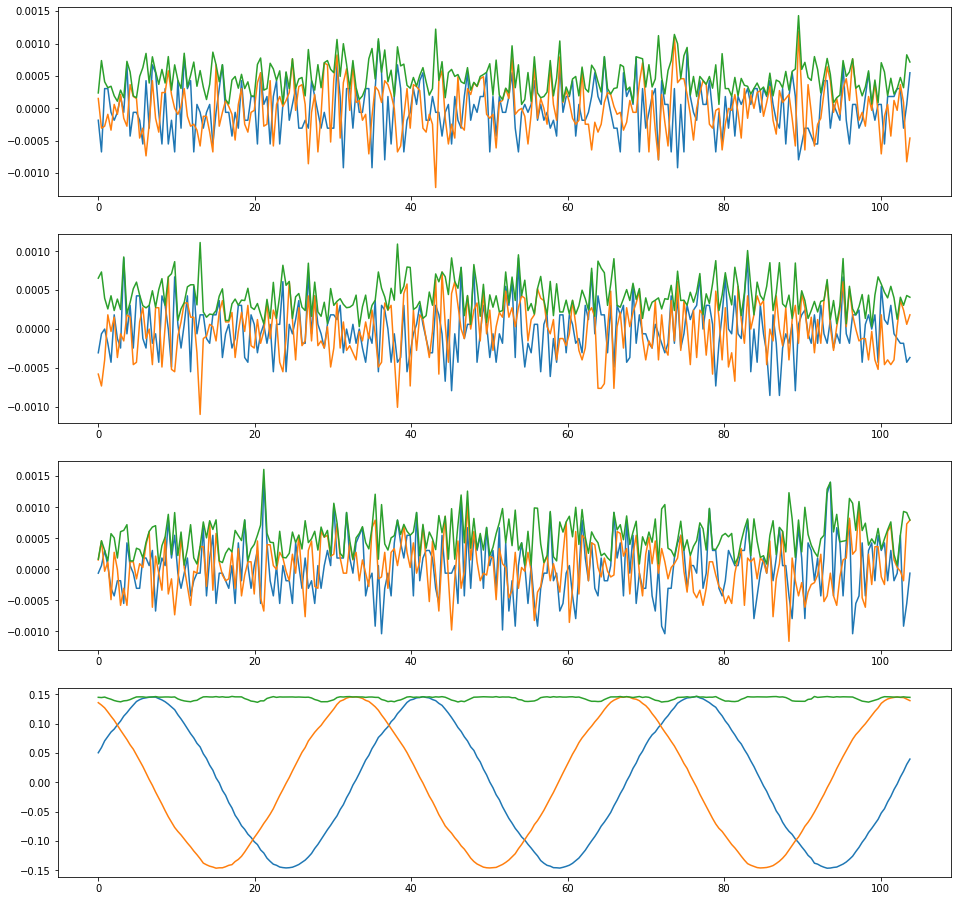

In [16]:
f_s = 2457.6e6
sample_times = np.arange(0, number_samples/f_s, 1/f_s)*1e9

fig, axs = plt.subplots(4, figsize=(16,16))
for i in range(4):
    reals = np.real(cdata[i])
    imags = np.imag(cdata[i])
    moduli = np.abs(cdata[i])
    axs[i].plot(sample_times, reals)
    axs[i].plot(sample_times, imags)
    axs[i].plot(sample_times, moduli)


Again, the ADC labels are also reversed: ADC_A = channel 3, ADC_B = channel 2, etc.

Peak frequency: 123.394 MHz


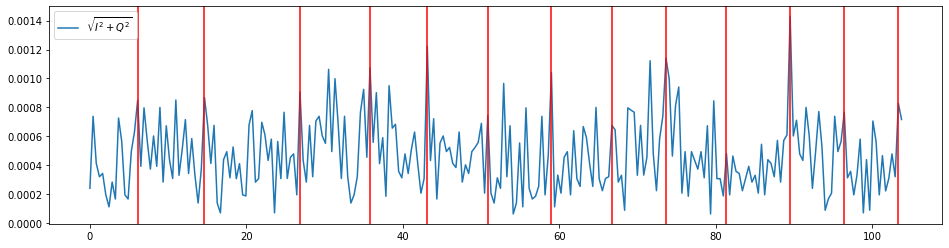

In [17]:
from scipy.signal import find_peaks

erasynth_ch = 0

reals = np.real(cdata[erasynth_ch])
imags = np.imag(cdata[erasynth_ch])
moduli = np.abs(cdata[erasynth_ch])
peak_inds = find_peaks(moduli, distance=16)[0]
avg_dt = np.average(np.diff(sample_times[peak_inds]))
print(f'Peak frequency: {round(1e3/avg_dt, 3)} MHz')

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(sample_times, moduli, label='$\sqrt{I^2 + Q^2}$')
for peak_ind in peak_inds:
    ax.axvline(sample_times[peak_ind], color='red')
ax.legend()


The above is troubleshooting the periodic fluctuations in the ERASynth $V_{\text{RMS}}$. It was originally doing something much more drastic with sharp peaks on a smoothish 80 MHz sine wave, but now it appears to be behaving much better. 